In [4]:
from ultralytics import YOLO
import zipfile
import shutil
from pathlib import Path
import random
import yaml
import cv2
import matplotlib.pyplot as plt

In [5]:
# Setup
base_dir = Path("data")
output_images = Path("yolo_dataset/images")
output_labels = Path("yolo_dataset/labels")
output_images.mkdir(parents=True, exist_ok=True)
output_labels.mkdir(parents=True, exist_ok=True)

# People folders
people = ["andrea", "taara", "chekayli"]

# Main loop
for person in people:
    print(f"Processing {person}...")

    image_dir = base_dir / person
    annotation_dir = base_dir / f"{person}_annotated"
    annotation_zip = annotation_dir / f"{person}_annotations.zip"
    unzip_dir = annotation_dir / "unzipped"

    # Unzip if needed
    if not unzip_dir.exists():
        with zipfile.ZipFile(annotation_zip, 'r') as zip_ref:
            zip_ref.extractall(unzip_dir)
            print(f"Unzipped {annotation_zip.name}")
    else:
        print(f"Already unzipped {annotation_zip.name}")

    # Some exports nest txts inside a subfolder
    txt_candidates = list(unzip_dir.rglob("*.txt"))
    txt_dir = txt_candidates[0].parent if txt_candidates else None

    if not txt_dir:
        print(f"[!] No .txt files found in {person}'s annotations.")
        continue

    for img_path in image_dir.glob("*.[jpJP][pnPN]*[gG]"):  # matches jpg/jpeg/png
        # Copy image
        dest_img = output_images / img_path.name
        shutil.copy(img_path, dest_img)

        # Copy or create empty label
        label_path = txt_dir / (img_path.stem + ".txt")
        dest_label = output_labels / (img_path.stem + ".txt")

        if label_path.exists():
            shutil.copy(label_path, dest_label)
        else:
            dest_label.touch()  # Create empty label for no-trash image

print("✅ Dataset ready for YOLO training.")

Processing andrea...
Already unzipped andrea_annotations.zip
Processing taara...
Already unzipped taara_annotations.zip
Processing chekayli...
Already unzipped chekayli_annotations.zip
✅ Dataset ready for YOLO training.


In [6]:
# Directories
base_dir = Path("yolo_dataset")
img_dir = base_dir / "images"
lbl_dir = base_dir / "labels"

# New split dirs
train_img_dir = img_dir / "train"
val_img_dir = img_dir / "val"
train_lbl_dir = lbl_dir / "train"
val_lbl_dir = lbl_dir / "val"

# Create folders
for folder in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    folder.mkdir(parents=True, exist_ok=True)

# Get image list
all_imgs = list(img_dir.glob("*.jpg")) + list(img_dir.glob("*.png"))
random.seed(42)
random.shuffle(all_imgs)

# 80/20 train/val split
split_idx = int(0.8 * len(all_imgs))
train_imgs = all_imgs[:split_idx]
val_imgs = all_imgs[split_idx:]

def move_pair(img_paths, img_dst, lbl_dst):
    for img_path in img_paths:
        label_path = lbl_dir / (img_path.stem + ".txt")
        shutil.move(str(img_path), img_dst / img_path.name)
        if label_path.exists():
            shutil.move(str(label_path), lbl_dst / label_path.name)
        else:
            (lbl_dst / (img_path.stem + ".txt")).touch()

# Move images and labels
move_pair(train_imgs, train_img_dir, train_lbl_dir)
move_pair(val_imgs, val_img_dir, val_lbl_dir)

# Remove flat image/label folders
for d in [img_dir, lbl_dir]:
    for item in d.glob("*.jpg"):
        item.unlink()
    for item in d.glob("*.png"):
        item.unlink()
    for item in d.glob("*.txt"):
        item.unlink()

# Generate dataset.yaml
dataset_yaml = {
    'path': str(base_dir.resolve()),
    'train': 'images/train',
    'val': 'images/val',
    'names': {0: 'Trash'}
}

with open("dataset.yaml", "w") as f:
    yaml.dump(dataset_yaml, f)

print("✅ Split complete. `dataset.yaml` created.")

✅ Split complete. `dataset.yaml` created.


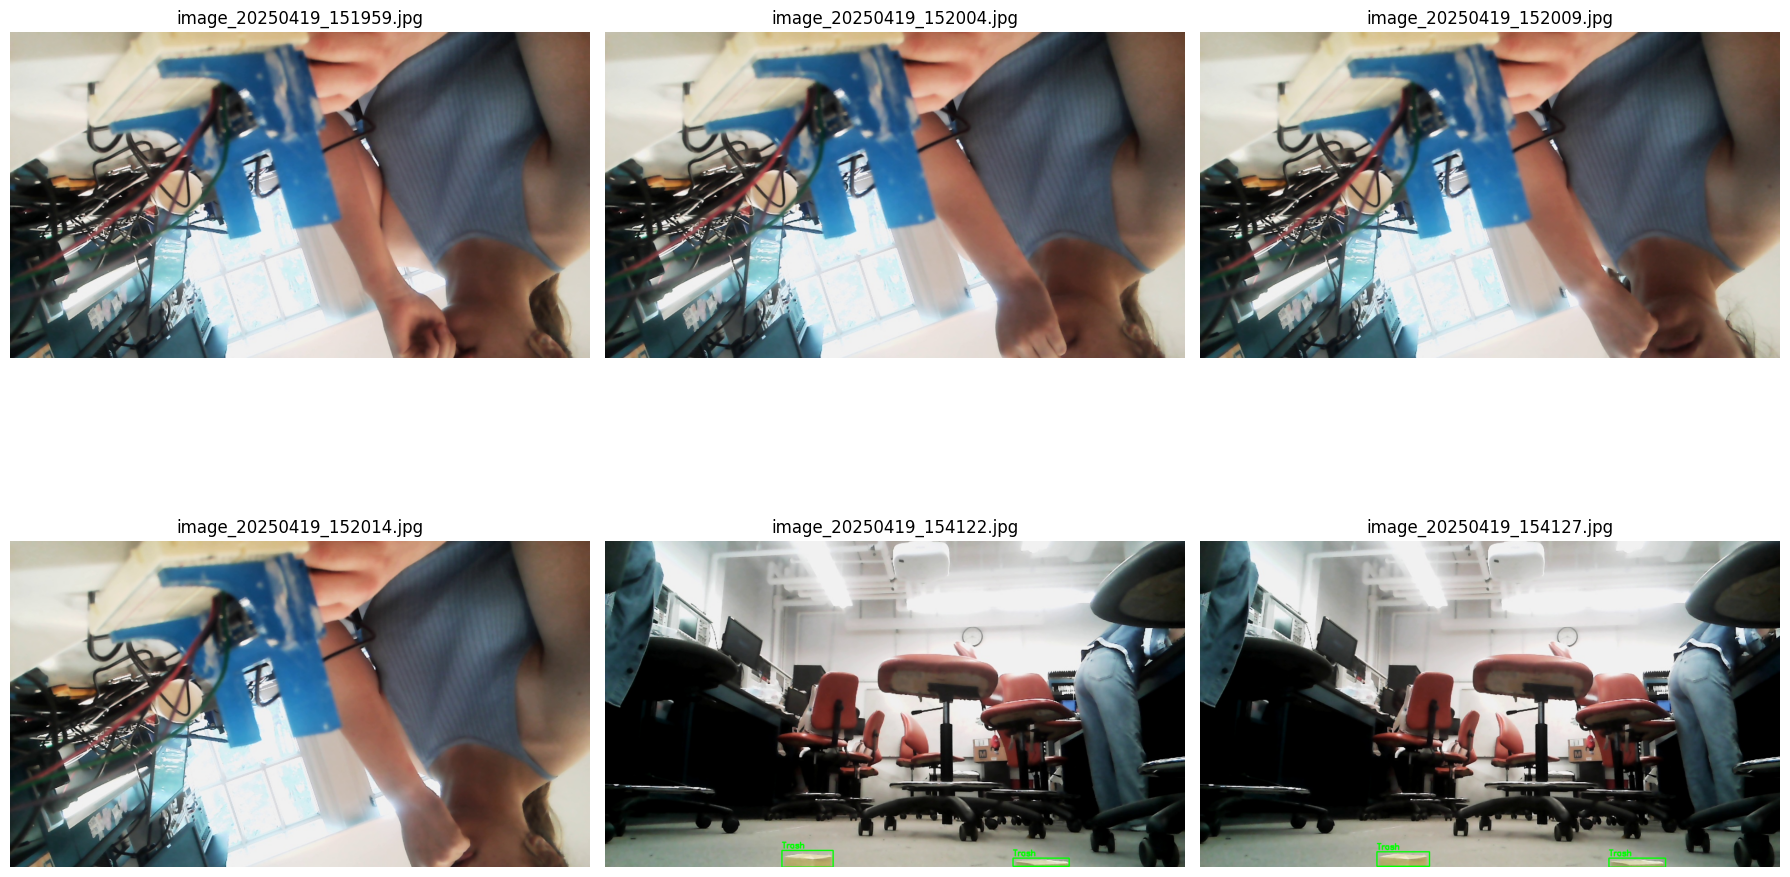

In [7]:
def draw_yolo_boxes(image_path, label_path, class_names={0: "Trash"}, box_color=(0, 255, 0)):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if label_path.exists():
        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                class_id, x_center, y_center, width, height = map(float, parts)
                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), box_color, 2)
                label = class_names.get(int(class_id), str(class_id))
                cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_color, 2)

    return img

# Load up to 6 samples
img_dir = Path("yolo_dataset/images/train")
lbl_dir = Path("yolo_dataset/labels/train")
img_paths = sorted(list(img_dir.glob("*.jpg")) + list(img_dir.glob("*.png")))[:6]

plt.figure(figsize=(18, 12))
for idx, img_path in enumerate(img_paths):
    label_path = lbl_dir / (img_path.stem + ".txt")
    preview_img = draw_yolo_boxes(img_path, label_path)

    plt.subplot(2, 3, idx + 1)
    plt.imshow(preview_img)
    plt.axis("off")
    plt.title(img_path.name)

plt.tight_layout()
plt.show()

In [8]:
# Load a model
# model = YOLO("yolo11n.yaml")  # build a new model from YAML
# model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)
# model = YOLO("yolo11n.yaml").load("yolo11n.pt")  # build from YAML and transfer weights
model = YOLO("yolov5n.pt")

PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [9]:
# Train the model
model.train(
    data="dataset.yaml",
    epochs=100,
    imgsz=(416, 416),
    name="yolotrash-32",
    project="/home/andrea/ese3500/yolo11-model/runs"
)

New https://pypi.org/project/ultralytics/8.3.114 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.111 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
engine/trainer: task=detect, mode=train, model=yolov5n.pt, data=dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=(416, 416), save=True, save_period=-1, cache=False, device=None, workers=8, project=/home/andrea/ese3500/yolo11-model/runs, name=yolotrash-322, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina

  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    296448  ultralytics.nn.modules.block.C3              [256,

train: Scanning /home/andrea/ese3500/taaranator_rpi/yolo11-model/yolo_dataset/labels/train... 300 images, 92 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 1802.62it/s]

train: New cache created: /home/andrea/ese3500/taaranator_rpi/yolo11-model/yolo_dataset/labels/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1695.3±1502.4 MB/s, size: 141.5 KB)


val: Scanning /home/andrea/ese3500/taaranator_rpi/yolo11-model/yolo_dataset/labels/val... 75 images, 23 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 748.66it/s]

val: New cache created: /home/andrea/ese3500/taaranator_rpi/yolo11-model/yolo_dataset/labels/val.cache


Plotting labels to /home/andrea/ese3500/yolo11-model/runs/yolotrash-322/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to /home/andrea/ese3500/yolo11-model/runs/yolotrash-322
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.945G      1.083      2.604     0.9879         42        416: 100%|██████████| 19/19 [00:02<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.28it/s]

                   all         75        108     0.0058      0.935      0.487      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.994G     0.9881      1.315     0.9331         24        416: 100%|██████████| 19/19 [00:01<00:00, 14.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.59it/s]

                   all         75        108      0.942      0.448      0.561      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         1G     0.9734      1.132      0.946         31        416: 100%|██████████| 19/19 [00:01<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.51it/s]

                   all         75        108          1      0.513      0.768      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.01G     0.9484      1.034     0.9496         28        416: 100%|██████████| 19/19 [00:01<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.80it/s]


                   all         75        108          1      0.663      0.801      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.01G     0.9934      1.017     0.9646         26        416: 100%|██████████| 19/19 [00:00<00:00, 25.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.55it/s]

                   all         75        108      0.958      0.861      0.934       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.03G     0.9807     0.9307     0.9612         28        416: 100%|██████████| 19/19 [00:01<00:00, 14.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.94it/s]

                   all         75        108      0.917      0.918      0.961      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      7/100      1.03G     0.9879     0.9223     0.9579         37        416: 100%|██████████| 19/19 [00:01<00:00, 15.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.07it/s]


                   all         75        108      0.934      0.913      0.946      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.03G     0.9678     0.8706     0.9666         26        416: 100%|██████████| 19/19 [00:01<00:00, 15.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.35it/s]


                   all         75        108      0.835      0.741      0.804      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.03G     0.9276     0.8505     0.9423         30        416: 100%|██████████| 19/19 [00:01<00:00, 15.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.45it/s]

                   all         75        108      0.973      0.861      0.933      0.671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     10/100      1.04G     0.9471      0.832     0.9753         36        416: 100%|██████████| 19/19 [00:01<00:00, 15.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.29it/s]

                   all         75        108      0.964      0.898      0.948      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     11/100      1.05G     0.9239     0.7798      0.951         30        416: 100%|██████████| 19/19 [00:01<00:00, 15.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.76it/s]


                   all         75        108       0.95      0.874      0.935      0.682

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.06G     0.8763     0.7395     0.9337         34        416: 100%|██████████| 19/19 [00:01<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.33it/s]

                   all         75        108      0.918      0.931      0.948      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.06G     0.9102     0.7521     0.9441         30        416: 100%|██████████| 19/19 [00:01<00:00, 15.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.30it/s]

                   all         75        108       0.97      0.886      0.949      0.723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     14/100      1.06G     0.8649       0.68     0.9099         31        416: 100%|██████████| 19/19 [00:01<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.24it/s]


                   all         75        108      0.923      0.898      0.954      0.711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.06G     0.8421     0.6556      0.906         29        416: 100%|██████████| 19/19 [00:01<00:00, 15.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.55it/s]

                   all         75        108      0.948      0.944      0.957      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.08G     0.8598     0.6636     0.9298         40        416: 100%|██████████| 19/19 [00:01<00:00, 15.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 12.95it/s]

                   all         75        108      0.936      0.953      0.955      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.08G     0.8639     0.6457     0.9313         30        416: 100%|██████████| 19/19 [00:01<00:00, 15.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.29it/s]

                   all         75        108       0.95      0.875      0.943      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.08G     0.8589     0.6435     0.9456         27        416: 100%|██████████| 19/19 [00:01<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.82it/s]


                   all         75        108      0.978      0.917      0.956      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.08G     0.8592     0.6339     0.9315         38        416: 100%|██████████| 19/19 [00:01<00:00, 15.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.36it/s]

                   all         75        108      0.975      0.898      0.955        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.08G     0.8541     0.6319     0.9224         29        416: 100%|██████████| 19/19 [00:01<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.84it/s]

                   all         75        108      0.918      0.926      0.943      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.08G     0.7742     0.5928     0.9064         35        416: 100%|██████████| 19/19 [00:01<00:00, 15.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.68it/s]

                   all         75        108       0.97      0.944       0.97      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     22/100      1.08G     0.7871      0.594     0.8919         37        416: 100%|██████████| 19/19 [00:01<00:00, 15.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.66it/s]

                   all         75        108      0.922      0.944      0.957      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.08G     0.8218     0.5858     0.9191         45        416: 100%|██████████| 19/19 [00:01<00:00, 15.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.14it/s]

                   all         75        108      0.964      0.889      0.953      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     24/100      1.08G     0.8019     0.5728     0.8933         31        416: 100%|██████████| 19/19 [00:01<00:00, 15.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.30it/s]

                   all         75        108      0.971      0.924       0.96      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.08G     0.8008     0.5829     0.9075         31        416: 100%|██████████| 19/19 [00:00<00:00, 26.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.30it/s]

                   all         75        108      0.928      0.963      0.967      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.08G     0.7973     0.5877     0.9103         29        416: 100%|██████████| 19/19 [00:01<00:00, 15.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.73it/s]

                   all         75        108      0.962      0.939      0.963      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     27/100      1.08G     0.8115     0.5501     0.9171         48        416: 100%|██████████| 19/19 [00:01<00:00, 15.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.88it/s]


                   all         75        108      0.987      0.972      0.975      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.08G     0.7536     0.5309     0.8987         27        416: 100%|██████████| 19/19 [00:01<00:00, 15.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.61it/s]

                   all         75        108      0.954      0.958      0.971      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.08G     0.7732     0.5318     0.8954         23        416: 100%|██████████| 19/19 [00:01<00:00, 15.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.66it/s]

                   all         75        108          1      0.972      0.983      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.08G      0.739     0.5105     0.8892         34        416: 100%|██████████| 19/19 [00:01<00:00, 15.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.29it/s]

                   all         75        108       0.99      0.962      0.979      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.08G     0.7639     0.5249     0.9132         31        416: 100%|██████████| 19/19 [00:01<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.14it/s]

                   all         75        108       0.95      0.963      0.977      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.08G      0.729     0.5046     0.8965         30        416: 100%|██████████| 19/19 [00:01<00:00, 15.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.50it/s]

                   all         75        108      0.954      0.972      0.974      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.08G     0.7401     0.5207     0.9043         33        416: 100%|██████████| 19/19 [00:01<00:00, 15.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.53it/s]

                   all         75        108          1      0.934      0.983      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.08G     0.7275     0.4957      0.888         23        416: 100%|██████████| 19/19 [00:01<00:00, 15.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.83it/s]

                   all         75        108      0.971      0.954       0.98      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.08G     0.7467     0.4982     0.8924         20        416: 100%|██████████| 19/19 [00:01<00:00, 15.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.41it/s]

                   all         75        108      0.966      0.944      0.964      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     36/100      1.08G     0.7305     0.4786     0.8902         29        416: 100%|██████████| 19/19 [00:01<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.85it/s]

                   all         75        108      0.981      0.958      0.966      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     37/100      1.08G     0.7288     0.4882     0.8838         32        416: 100%|██████████| 19/19 [00:01<00:00, 16.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.11it/s]

                   all         75        108      0.986      0.972      0.984      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.08G     0.7075     0.4847     0.8814         22        416: 100%|██████████| 19/19 [00:01<00:00, 15.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.33it/s]

                   all         75        108      0.965      0.963      0.973      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.08G     0.7147      0.491      0.888         34        416: 100%|██████████| 19/19 [00:01<00:00, 15.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.18it/s]

                   all         75        108      0.972      0.966      0.977      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     40/100      1.08G     0.7016     0.4757     0.8793         31        416: 100%|██████████| 19/19 [00:01<00:00, 15.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.28it/s]

                   all         75        108      0.981      0.953      0.985      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.08G      0.689     0.4587     0.8712         26        416: 100%|██████████| 19/19 [00:01<00:00, 15.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.54it/s]

                   all         75        108      0.997      0.972      0.985      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     42/100      1.08G     0.7074     0.4598     0.8794         34        416: 100%|██████████| 19/19 [00:01<00:00, 14.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.48it/s]

                   all         75        108      0.998      0.972      0.986      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.09G     0.6995     0.4676      0.886         35        416: 100%|██████████| 19/19 [00:01<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.71it/s]


                   all         75        108       0.99      0.962      0.975      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.09G     0.7098     0.4689     0.8784         31        416: 100%|██████████| 19/19 [00:01<00:00, 15.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.69it/s]

                   all         75        108          1      0.963      0.984      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.09G     0.6993      0.479     0.8952         30        416: 100%|██████████| 19/19 [00:00<00:00, 26.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.25it/s]

                   all         75        108       0.99      0.972      0.985      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.09G     0.6574     0.4446     0.8811         35        416: 100%|██████████| 19/19 [00:01<00:00, 14.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.57it/s]

                   all         75        108      0.997      0.972      0.986      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     47/100      1.09G     0.6701     0.4506     0.8854         36        416: 100%|██████████| 19/19 [00:01<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.86it/s]

                   all         75        108      0.996      0.972      0.985      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     48/100      1.09G     0.6671     0.4547     0.8779         25        416: 100%|██████████| 19/19 [00:01<00:00, 15.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.91it/s]

                   all         75        108      0.997      0.963      0.988      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     49/100      1.09G     0.6959     0.4557     0.8785         29        416: 100%|██████████| 19/19 [00:01<00:00, 15.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.76it/s]

                   all         75        108      0.999      0.963      0.988      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.09G     0.6406     0.4438     0.8847         21        416: 100%|██████████| 19/19 [00:01<00:00, 15.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.28it/s]

                   all         75        108      0.995      0.972       0.99      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.09G     0.6421     0.4254     0.8692         17        416: 100%|██████████| 19/19 [00:01<00:00, 15.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.81it/s]

                   all         75        108      0.995      0.954      0.986      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.09G     0.6898     0.4618     0.8872         23        416: 100%|██████████| 19/19 [00:01<00:00, 15.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.67it/s]

                   all         75        108      0.972      0.972       0.99      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     53/100      1.09G      0.634     0.4263      0.891         27        416: 100%|██████████| 19/19 [00:01<00:00, 15.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.99it/s]

                   all         75        108      0.972      0.968      0.985      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.09G     0.6807     0.4354     0.8748         20        416: 100%|██████████| 19/19 [00:01<00:00, 15.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.87it/s]

                   all         75        108      0.988      0.972      0.985      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     55/100      1.09G     0.6306     0.4125     0.8641         32        416: 100%|██████████| 19/19 [00:01<00:00, 14.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.35it/s]

                   all         75        108          1      0.964      0.979      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.09G     0.6166     0.4173     0.8583         28        416: 100%|██████████| 19/19 [00:01<00:00, 15.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.18it/s]

                   all         75        108      0.991      0.944      0.976      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.09G     0.6361     0.4163     0.8712         32        416: 100%|██████████| 19/19 [00:01<00:00, 15.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.94it/s]

                   all         75        108      0.999      0.963      0.978      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.09G     0.6332     0.4113     0.8675         39        416: 100%|██████████| 19/19 [00:01<00:00, 15.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.55it/s]

                   all         75        108      0.991      0.971       0.98      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.09G     0.6175     0.4169     0.8669         23        416: 100%|██████████| 19/19 [00:01<00:00, 15.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.57it/s]

                   all         75        108          1      0.971      0.987      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.09G     0.6287     0.4159     0.8702         20        416: 100%|██████████| 19/19 [00:01<00:00, 15.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.65it/s]

                   all         75        108      0.991      0.965      0.977      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.09G     0.6197     0.4186     0.8727         30        416: 100%|██████████| 19/19 [00:01<00:00, 15.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.47it/s]

                   all         75        108      0.999      0.981      0.987      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.09G     0.6232     0.4082     0.8651         34        416: 100%|██████████| 19/19 [00:01<00:00, 15.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.41it/s]

                   all         75        108      0.994      0.954      0.979      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.09G     0.6465     0.4123     0.8644         26        416: 100%|██████████| 19/19 [00:01<00:00, 15.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.82it/s]

                   all         75        108      0.991      0.978      0.987      0.816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     64/100      1.09G      0.612     0.4081     0.8592         31        416: 100%|██████████| 19/19 [00:01<00:00, 15.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.73it/s]

                   all         75        108       0.99      0.981      0.987      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.09G     0.6112      0.412     0.8587         29        416: 100%|██████████| 19/19 [00:00<00:00, 25.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.26it/s]

                   all         75        108      0.993      0.972      0.987      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.09G     0.6225     0.3912     0.8613         30        416: 100%|██████████| 19/19 [00:01<00:00, 15.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.83it/s]


                   all         75        108      0.999      0.981      0.987      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.09G     0.6045     0.3849     0.8491         26        416: 100%|██████████| 19/19 [00:01<00:00, 15.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.76it/s]

                   all         75        108      0.989      0.972      0.979      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     68/100      1.09G      0.587     0.3716     0.8638         44        416: 100%|██████████| 19/19 [00:01<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.69it/s]

                   all         75        108      0.991      0.972      0.978      0.817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     69/100      1.09G     0.5925     0.3797      0.859         41        416: 100%|██████████| 19/19 [00:01<00:00, 14.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.58it/s]

                   all         75        108          1      0.979      0.987      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     70/100      1.09G     0.6019     0.3898     0.8616         38        416: 100%|██████████| 19/19 [00:01<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.23it/s]

                   all         75        108      0.972      0.971      0.977      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.09G     0.5867     0.3883     0.8517         44        416: 100%|██████████| 19/19 [00:01<00:00, 14.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.64it/s]

                   all         75        108          1      0.971      0.987      0.815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     72/100      1.09G     0.5882     0.3791     0.8534         27        416: 100%|██████████| 19/19 [00:01<00:00, 14.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.93it/s]

                   all         75        108       0.98      0.981      0.987      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.09G     0.5841     0.3802     0.8582         38        416: 100%|██████████| 19/19 [00:01<00:00, 15.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.42it/s]

                   all         75        108      0.989      0.981      0.987      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.09G     0.5621     0.3649       0.85         22        416: 100%|██████████| 19/19 [00:01<00:00, 14.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.14it/s]


                   all         75        108      0.989      0.972       0.98      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.09G      0.578     0.3715     0.8581         29        416: 100%|██████████| 19/19 [00:01<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.95it/s]


                   all         75        108      0.997      0.981      0.988      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.09G     0.5996     0.3816     0.8601         27        416: 100%|██████████| 19/19 [00:01<00:00, 14.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.41it/s]

                   all         75        108          1      0.981      0.988      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.09G      0.569     0.3713     0.8437         31        416: 100%|██████████| 19/19 [00:01<00:00, 15.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.09it/s]

                   all         75        108          1      0.972      0.987      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.09G     0.5673     0.3735     0.8519         18        416: 100%|██████████| 19/19 [00:01<00:00, 15.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.36it/s]

                   all         75        108      0.999      0.972      0.987      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.09G      0.564     0.3653     0.8477         47        416: 100%|██████████| 19/19 [00:01<00:00, 14.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.40it/s]

                   all         75        108      0.997      0.972      0.987      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.09G     0.5834     0.3674     0.8507         32        416: 100%|██████████| 19/19 [00:01<00:00, 15.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.04it/s]

                   all         75        108      0.988      0.972      0.987      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.09G     0.5557     0.3628     0.8536         24        416: 100%|██████████| 19/19 [00:01<00:00, 14.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.50it/s]

                   all         75        108      0.981      0.963       0.98      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.09G     0.5534     0.3523     0.8373         36        416: 100%|██████████| 19/19 [00:01<00:00, 15.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.09it/s]

                   all         75        108      0.979      0.963      0.979      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     83/100      1.09G     0.5668     0.3634     0.8611         22        416: 100%|██████████| 19/19 [00:01<00:00, 14.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.23it/s]

                   all         75        108      0.988      0.972      0.987      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.09G     0.5915     0.3668     0.8599         37        416: 100%|██████████| 19/19 [00:01<00:00, 14.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.45it/s]

                   all         75        108      0.994      0.972      0.986      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.09G     0.5739     0.3653     0.8436         41        416: 100%|██████████| 19/19 [00:01<00:00, 15.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.13it/s]

                   all         75        108      0.996      0.972      0.987      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.09G     0.5405     0.3519     0.8434         30        416: 100%|██████████| 19/19 [00:01<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 17.36it/s]

                   all         75        108          1       0.97      0.987      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.09G     0.5433     0.3452       0.83         27        416: 100%|██████████| 19/19 [00:01<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.81it/s]


                   all         75        108      0.988      0.981      0.987      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.09G     0.5473     0.3421     0.8405         39        416: 100%|██████████| 19/19 [00:01<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.07it/s]

                   all         75        108       0.97      0.963      0.978      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.09G     0.5396      0.348     0.8369         33        416: 100%|██████████| 19/19 [00:01<00:00, 14.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.27it/s]

                   all         75        108      0.994      0.963      0.987      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.09G     0.5519     0.3528     0.8466         23        416: 100%|██████████| 19/19 [00:01<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.06it/s]

                   all         75        108          1      0.978      0.988      0.839


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.09G     0.5194     0.3449     0.8373         11        416: 100%|██████████| 19/19 [00:01<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.57it/s]

                   all         75        108      0.998      0.981      0.987      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.09G     0.5176     0.3367      0.845         11        416: 100%|██████████| 19/19 [00:01<00:00, 14.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.41it/s]

                   all         75        108      0.998      0.981      0.987      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.09G     0.5249     0.3308     0.8241         14        416: 100%|██████████| 19/19 [00:01<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.61it/s]

                   all         75        108          1      0.979      0.987      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.09G     0.5052     0.3236     0.8442         14        416: 100%|██████████| 19/19 [00:01<00:00, 15.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.47it/s]

                   all         75        108       0.98      0.972      0.978       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     95/100      1.09G      0.517     0.3279     0.8387         14        416: 100%|██████████| 19/19 [00:01<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.43it/s]

                   all         75        108       0.98      0.972      0.978      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.09G     0.5043     0.3293     0.8245         14        416: 100%|██████████| 19/19 [00:01<00:00, 14.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.53it/s]

                   all         75        108       0.98      0.972      0.979      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     97/100      1.09G     0.5175     0.3245     0.8212         14        416: 100%|██████████| 19/19 [00:01<00:00, 14.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.51it/s]

                   all         75        108       0.99      0.972      0.979      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.09G     0.4956     0.3216     0.8424         13        416: 100%|██████████| 19/19 [00:01<00:00, 15.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 15.28it/s]

                   all         75        108       0.99      0.972       0.98      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.09G     0.4758     0.3081     0.8252          8        416: 100%|██████████| 19/19 [00:01<00:00, 15.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.20it/s]

                   all         75        108       0.99      0.972       0.98      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.09G      0.506     0.3171     0.8272         13        416: 100%|██████████| 19/19 [00:01<00:00, 14.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 14.50it/s]

                   all         75        108       0.99      0.972       0.98      0.839



100 epochs completed in 0.045 hours.
Optimizer stripped from /home/andrea/ese3500/yolo11-model/runs/yolotrash-322/weights/last.pt, 5.2MB
Optimizer stripped from /home/andrea/ese3500/yolo11-model/runs/yolotrash-322/weights/best.pt, 5.2MB

Validating /home/andrea/ese3500/yolo11-model/runs/yolotrash-322/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.92it/s]


                   all         75        108      0.981      0.963       0.98      0.843
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /home/andrea/ese3500/yolo11-model/runs/yolotrash-322


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa7357593a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [10]:
# Load model
model = YOLO("/home/andrea/ese3500/yolo11-model/runs/yolotrash-322/weights/best.pt")

# Input source (can be a folder or a single image)
source = "yolo_dataset/images/val"  # change this to your test folder or image

# Output directory (must not exist or YOLO will auto-increment)
save_dir = Path("yoltrash-v2/predictions")
save_dir.mkdir(parents=True, exist_ok=True)  # create if needed

# Run prediction
results = model.predict(
    source=source,
    imgsz=416,
    save=True,
    save_txt=True,      # optional: saves YOLO format .txt labels
    project=str(save_dir.parent),
    name=save_dir.name,
    exist_ok=True       # allows overwriting the dir
)

print(f"Predictions saved in: {save_dir.resolve()}")



image 1/75 /home/andrea/ese3500/taaranator_rpi/yolo11-model/yolo_dataset/images/val/image_20250419_151954.jpg: 256x416 (no detections), 44.7ms
image 2/75 /home/andrea/ese3500/taaranator_rpi/yolo11-model/yolo_dataset/images/val/image_20250419_154116.jpg: 256x416 2 Trashs, 39.5ms
image 3/75 /home/andrea/ese3500/taaranator_rpi/yolo11-model/yolo_dataset/images/val/image_20250419_154147.jpg: 256x416 2 Trashs, 32.0ms
image 4/75 /home/andrea/ese3500/taaranator_rpi/yolo11-model/yolo_dataset/images/val/image_20250419_154217.jpg: 256x416 2 Trashs, 30.3ms
image 5/75 /home/andrea/ese3500/taaranator_rpi/yolo11-model/yolo_dataset/images/val/image_20250419_154247.jpg: 256x416 3 Trashs, 32.8ms
image 6/75 /home/andrea/ese3500/taaranator_rpi/yolo11-model/yolo_dataset/images/val/image_20250419_154317.jpg: 256x416 2 Trashs, 17.7ms
image 7/75 /home/andrea/ese3500/taaranator_rpi/yolo11-model/yolo_dataset/images/val/image_20250419_154323.jpg: 256x416 2 Trashs, 14.5ms
image 8/75 /home/andrea/ese3500/taaranat

In [11]:
# Load the YOLO11 model
model = YOLO("/home/andrea/ese3500/yolo11-model/runs/yolotrash-322/weights/best.pt")

# Export the model to ONNX format
model.export(format="onnx", imgsz=320)

Ultralytics 8.3.111 🚀 Python-3.12.3 torch-2.6.0+cu124 CPU (13th Gen Intel Core(TM) i9-13980HX)
YOLOv5n summary (fused): 84 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs

PyTorch: starting from '/home/andrea/ese3500/yolo11-model/runs/yolotrash-322/weights/best.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 5, 2100) (5.0 MB)
requirements: Ultralytics requirement ['onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 26.0 MB/s eta 0:00:0000:0100:01

requirements: AutoUpdate success ✅ 14.0s, installed 1 package: ['onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.50...
ONNX: export success ✅ 14.5s, saved as '/home/andrea/ese3500/yolo11-model/runs/yolotrash-322/weights/best.onnx' (9.7 MB)

Export complete (14.6s)
Results saved to /home/andrea/ese3500/yolo11-model/runs/yolotra

'/home/andrea/ese3500/yolo11-model/runs/yolotrash-322/weights/best.onnx'